In [3]:
"""
This file is implementing the vanilla LSTM.
The test set used are the 31 days of December of a single time-serie of the 261 time-series with measurements of the full year 2017.
Missing days are estimated.
Naive basemodels that are used are the mean forecast and the MAPE-minimization.
Evaluation metrics used: MSE, RMSE, NRMSE, MAE
####################################################

calculate the MSE on the total test set and for each day of the week.
Should normalize history and temperature with min max
Rest: weekday, time, holiday use one hot encoder
Stack different LSTM blocks --> hidden nodes serve as inputs for next LSTM's
Use finally a fully connected layer to generate an output
Use different learning rules: adam!!, stochastic gradient descent, Adagrad, Adadelta and RMSProp
Adam has parameters: learning rate, momentum and decay
play with mini batches

Inputs:
1. history ok
2. temp ok
3. day week ok
4. time ok
5. holiday
6. (previous week future lag)
7. previous week error history lag --> how good are you following previous week
just the difference between the values
8. previous weeks load at the same moment in time and the temperatures of these days
"""


"\nThis file is implementing the vanilla LSTM.\nThe test set used are the 31 days of December of a single time-serie of the 261 time-series with measurements of the full year 2017.\nMissing days are estimated.\nNaive basemodels that are used are the mean forecast and the MAPE-minimization.\nEvaluation metrics used: MSE, RMSE, NRMSE, MAE\n####################################################\n\ncalculate the MSE on the total test set and for each day of the week.\nShould normalize history and temperature with min max\nRest: weekday, time, holiday use one hot encoder\nStack different LSTM blocks --> hidden nodes serve as inputs for next LSTM's\nUse finally a fully connected layer to generate an output\nUse different learning rules: adam!!, stochastic gradient descent, Adagrad, Adadelta and RMSProp\nAdam has parameters: learning rate, momentum and decay\nplay with mini batches\n\nInputs:\n1. history ok\n2. temp ok\n3. day week ok\n4. time ok\n5. holiday\n6. (previous week future lag)\n7. p

In [4]:
from forecasting_functions import *

In [5]:
# importing the data
Stijn = True
fullYearpath = None
av_temperaturepath = None
if Stijn:
    fullYearpath = "D:\Onedrive\Leuven\Final project\data\Forecasting_writtendata\FullYear.csv"
    av_temperaturepath = "D:\Onedrive\Leuven\Final project\data\weather-avg.csv"
else:
    raise Exception("Put some paths here.")
fullYeardata = pd.read_csv(fullYearpath,index_col= "date",parse_dates= True)
av_temperature = pd.read_csv(av_temperaturepath,index_col='meter_id')
av_temperature = av_temperature.transpose()
av_temperature.index = pd.to_datetime(av_temperature.index)

In [6]:
# parameters


In [7]:
name = fullYeardata.columns[1]
TS = fullYeardata[name]
temperature = av_temperature[name]

In [8]:
# all the training dates are present, dates from the test set can be missing.

# normalize the data --> min/max method (when using a single time serie)
temperature_norm,scaler_temperature = norm_forcast(temperature)
temperature_norm = substitute_missing_values_temperature(temperature_norm)
TS_norm,scaler_history = norm_forcast(TS)
temp = TS_norm[TS_norm.index.month == 1]
# temp = TS_norm[TS_norm.index.month != 12]
# test = TS_norm[TS_norm.index.month == 12]

# remove from the test set all the days that contain nan values -> only estimate real days
# test.dropna(inplace=True)

# substitute the missing values
temp = substitute_missing_values(temp)
training = temp[0:336]
validation = temp[336:384]
test = temp[384:528]
# training = temp[temp.index.month != 11]
# validation = temp[temp.index.month == 11]
TS_norm_full = substitute_missing_values(TS_norm.copy(deep=True))

amount of missing values: 0. 

amount of missing values: 0. 

amount of missing values: 0. 



In [9]:
# maybe better to use the relu function instead of tanh.
# data is between 0 and one
from keras.layers import Dense,  LSTM,Embedding
from keras.models import Sequential, save_model, load_model
from keras import regularizers
from keras.callbacks import EarlyStopping,ModelCheckpoint, History

#
def build_model_stateless1(training: pd.Series,validation: pd.Series, temperature_norm: pd.Series, lag_value: int,nb_epoch: int = 1, regularization_parameter: float = 0.01,batch_size_para: int = 32,verbose_para: int = 1, save: bool = False):
    history = History()
    X,y = input_output_LSTM(training, temperature_norm, lag_value)
    X_val,y_val = input_output_LSTM(validation, temperature_norm, lag_value)
    regularizers.l2(l=regularization_parameter)
    model = Sequential()
    # no initial state is given --> hidden state are tensors filled with zeros
    # dropout=None,recurrent_dropout=None
    model.add(LSTM(units=20,activation='tanh',input_shape=(X.shape[1],X.shape[2])))
    model.add(Dense(units=20,activation='relu',kernel_regularizer='l2'))
    # model.add(Dropout(0.10))
    model.add(Dense(units=y.shape[1],activation='relu',kernel_regularizer='l2'))
    model.compile(optimizer='adam',loss='mse')
    early_stopping_monitor = EarlyStopping(patience=5,restore_best_weights=True)
    # shuffle false --> not shuffle the training data
    model.fit(x=X,y=y,epochs=nb_epoch,shuffle= False, batch_size=batch_size_para,validation_data=(X_val,y_val),callbacks=[early_stopping_monitor,history],verbose=verbose_para)
    # save the trained_model
    if save:
        file_path = "model.h5"
        save_model(model,file_path)

    return model,history

# model = load_model(filepath, compile = True)

In [10]:
# def def build_model_stateless1(training: pd.Series,validation: pd.Series, temperature_norm: pd.Series, lag_value: int,nb_epoch: int = 1, regularization_parameter: float = 0.01,batch_size_para: int = 32,verbose_para: int = 1, save: bool = False):

In [12]:
trained_model,hist = build_model_stateless1(training=training,validation=validation,temperature_norm=temperature_norm,lag_value=3,nb_epoch=150, verbose_para= 0)
# trained_model.save('model.h5')
# model = load_model("D:\AI_time_series_repos\TS_code\Forecasting\LSTM\model.h5")

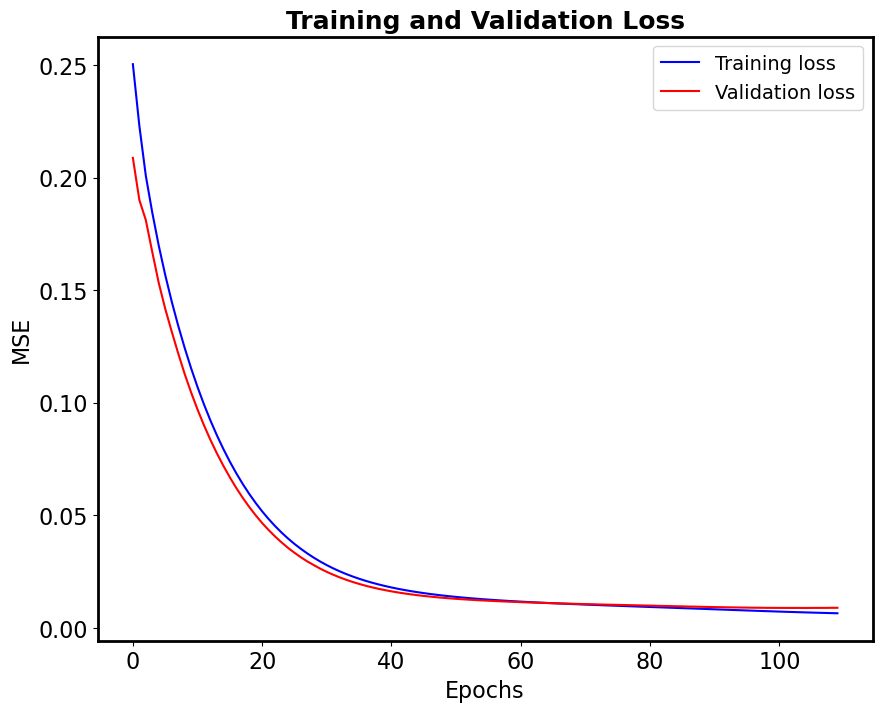

In [13]:
def visualize_loss(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    figure_layout(figsize=(10,8),titel="Training and Validation Loss",xlabel="Epochs",ylabel="MSE",grid=False)
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.legend()
    # plt.show()

visualize_loss(hist)

In [ ]:
# trained_model.summary()

In [28]:
def daily_prediction_stateless1(model: Sequential, TS_norm_full: pd.Series, temperature_norm: pd.Series, lag_value: int, daily_time_stamps: pd.DatetimeIndex):
    if len(daily_time_stamps) != 48:
            raise Exception("The test data doesn't equal 48 steps.")
    TS_copy = TS_norm_full.copy(deep= True)
    history_predictions = pd.Series(index= daily_time_stamps)
    history_reference = pd.Series(index= daily_time_stamps)
    for i in np.arange(0,len(daily_time_stamps)):
        time_stamp = daily_time_stamps[i]
        index_time_stamp = TS_copy.index.get_loc(time_stamp) # want to predict the time_stamp
        start = index_time_stamp - lag_value
        end = index_time_stamp
        history = TS_copy[start:end+1]
        prediction_input, reference = input_output_LSTM(history, temperature_norm, lag_value) # also the value to predict should be given
        y_hat = model.predict(prediction_input)
        # integrate the prediction in the TS_copy to be used in the next iterate
        TS_copy[time_stamp] = y_hat
        history_predictions[time_stamp] = y_hat
        history_reference[time_stamp] = reference

    return history_predictions, history_reference

# print(time_step_prediction(model = trained_model, TS = TS, temperature_norm= temperature_norm, lag_value= 3, daily_time_stamps= pd.date_range(start=pd.Time)))


In [15]:
def get_all_days_of_year(serie: pd.Series)->set:
    collection = set()
    for date in serie.index:
        collection.add(date.dayofyear)
    return collection

In [16]:
def test_set_prediction(model: Sequential, TS_norm_full: pd.Series, temperature_norm: pd.Series, lag_value: int, test_set:pd.Series, real_values: bool = True):
    # assumption that the test set has no gaps in the dates is not valid
    collection = list(get_all_days_of_year(test_set))
    day_int = collection[0]
    daily_time_stamps = test_set[test_set.index.dayofyear == day_int].index
    (history_predictions, history_reference) = daily_prediction_stateless1(model, TS_norm_full, temperature_norm, lag_value, daily_time_stamps)
    all_predictions = history_predictions
    all_references = history_reference

    if len(collection) > 1:
        for day_int in collection[1:]:
            daily_time_stamps = test_set[test_set.index.dayofyear == day_int].index
            (history_predictions, history_reference) = daily_prediction_stateless1(model, TS_norm_full, temperature_norm, lag_value, daily_time_stamps)
            all_predictions = all_predictions.append(history_predictions)
            all_references = all_references.append(history_reference)

    if real_values:
        all_predictions = norm_inverse(all_predictions,scaler_history)
        all_references = norm_inverse(all_references,scaler_history)

    return all_predictions, all_references


In [17]:
from Test_basemodel_functions import Switcher

def get_performance(all_predictions: pd.Series, all_references: pd.Series, metric: str = 'NRMSE'):
    return Switcher(metric, all_predictions, all_references)

In [29]:
all_predictions, all_references = test_set_prediction(trained_model, TS_norm_full, temperature_norm, 3, test, True)
# print("all_predictions: %s \n."%all_predictions)
# print("all_references: %s \n."%all_references)

In [ ]:
def show_forecast(all_predictions, all_references, ID: str, day_int: str, save: bool):
    axis = figure_layout(figsize=(10,8),titel="",xlabel="date",ylabel="kWh", dpi= 300)
    labels = ["True Future", "Model Prediction"]

    all_references.plot(ax=axis, lw= 3.0, grid= True)
    all_predictions.plot(ax=axis, lw= 3.0, grid= True)
    axis.legend(labels)

    if save:
        path = "Vanilla_LSTM_figures/"
        fname = path + "ID" + ID + "_Day" + day_int + ".png"
        plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w', orientation='portrait', format=None,
                    transparent=False, bbox_inches='tight', pad_inches=0.1, metadata=None)

# show_forecast(all_predictions[0:48],all_references[0:48])

def show_all_forecasts(all_predictions, all_references,ID: str, save: bool = True):
    collection = get_all_days_of_year(all_predictions)
    for day_int in collection:
        predictions = all_predictions[all_predictions.index.dayofyear == day_int]
        references = all_references[all_references.index.dayofyear == day_int]
        show_forecast(predictions, references, ID, str(day_int), save)
    plt.show()

show_all_forecasts(all_predictions,all_references, name, True)

In [ ]:
def repeated_performance(TS_norm_full: pd.Series, training: pd.Series, validation: pd.Series, test: pd.Series, temperature_norm: pd.Series, lag_value = 3, nb_epoch = 150, vb = 0, repeat = 2):
    collection = []
    for i in range(repeat):
        trained_model,hist = build_model_stateless1(training=training,validation=validation,temperature_norm=temperature_norm,lag_value=lag_value,nb_epoch=nb_epoch, verbose_para= vb)
        all_predictions, all_references = test_set_prediction(trained_model, TS_norm_full, temperature_norm, lag_value, test, True)
        p = get_performance(all_predictions, all_references)
        collection.append(p)
    return np.array(collection)
df = pd.DataFrame()
df[TS.name] = repeated_performance(TS_norm_full, training, validation, test, temperature_norm, lag_value = 3, nb_epoch = 150, vb = 0, repeat = 2)



In [ ]:
import time as t
results_file_name = str(t.time()) + ".txt"
results_file = open(results_file_name, "w")
results_file.write("This file displays the results of the hyperparameter search.")
results_file.close()


In [ ]:
df = pd.DataFrame(data= np.arange(0,25,2))
df["1"] = np.zeros(13)
df.describe()